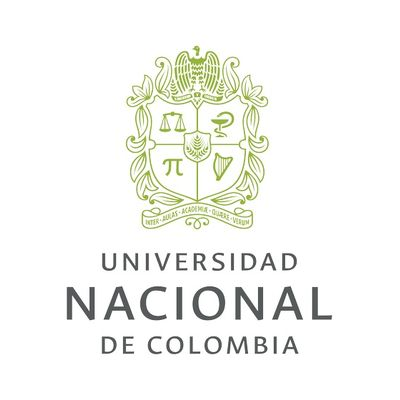


# Proyecto Computacion Estadistica
## Procesamiento De Direcciones

1.   Julian Mauricio Rodriguez Barreto

*El siguiente codigo describe una aplicacion en redes neuronales para el procesamiento de direcciones*

---



# Librerias

In [10]:
import collections
import logging
import os
import pathlib
import sys
import time
import json
from pickle import load
from pickle import dump
from numpy.random import shuffle

import mysql.connector 
import string
import re
from pickle import dump
from unicodedata import normalize
from pickle import load
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

from numpy import argmax
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 


import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import pad_sequences

# Datos

## Bajamos los datos guardados del georreferenciador

In [4]:

connmysl = mysql.connector.connect()
cursormysl = connmysl.cursor()
cursormysl.execute()
Direc = pd.DataFrame(cursormysl.fetchall()).rename(columns= {0: 'direccion',1: 'rpta'})
address=[]
delete=[]
for i in range(len(Direc)):
  try:
    di=json.loads(Direc['rpta'][i])
    address.append(di['response']['properties']['address'])
  except:
    delete.append(i)
Direc=Direc.drop(Direc.index[delete])
Direc['address']=address
Direc=Direc.loc[:,['address','direccion']]
np.savetxt('direc.txt', Direc.values, fmt='%s',delimiter='\t',newline='\n')

In [36]:
Direc

,address,direccion
0,CL 41 # 51 - 15,CL. 41 Nro. 51-15 LOCAL 105
1,CL 41 # 42 - 72,CL. 41 Nro. 42-72 LAURELES
2,CL 42 # 63C - 147,CL. 42 Nro. 63 C 147 CONQUISTADORES
3,CL 12 Sur # 25 - 127,Cl 12 Sur No 25-127 Ap 701 POBLADO
4,KR 63E # 103 - 14,CR 63E 103-14 BELARCAZAR BARRIO DE LAS C
...,...,...
42368,TV 4 # DG 34 - 00 CS 7 CALLE DE,transversal 4 diagonal 34 casa 7 calle de
42369,TV 9 # 17A - 155,transversal 9 17a 155 to 1
42370,TV 9 # 17A - 155,transversal 9 17a 155 barrio bavaria
42371,"Santa Marta, Magdalena, Colombia",transversal 9 n29e 46 apto 502


In [37]:
def load_doc(filename):
 # abrir el archivo como de sólo lectura
 file = open(filename, mode='rt', encoding='utf-8')
 # leer todo el texto
 text = file.read()
 # cerrar el archivo
 file.close()
 return text



 # dividir un documento cargado en oraciones
def to_pairs(doc):
 lines = doc.strip().split('\n')
 pairs = [line.split('\t') for line in lines]
 return pairs



def clean_pairs(lines):
 cleaned = list()
 # preparar lineas para el filtrado de caracteres
 for pair in lines:
  clean_pair = list()
  for line in pair:
   # normalizar los caracteres unicode
   line = normalize('NFD', line).encode('ascii','ignore')
   line = line.decode('UTF-8')
   # tokenize en espacio en blanco
   line = line.split()
   # convertir a minúsculas
   line = [word.lower() for word in line]
   # store como cadena
   clean_pair.append(' '.join(line))
  cleaned.append(clean_pair)
 return np.array(cleaned)



 # guardar una lista de direcciones limpias para archivar
def save_clean_data(sentences, filename):
 dump(sentences, open(filename,'wb'))
 print('Saved: %s'% filename)

## Carga y limpieza de direcciones

In [38]:

# cargar conjunto de datos
filename ='direc.txt'
doc = load_doc(filename)

# dividido en parejas de direcciones correctas -direcciones incorrectas
pairs = to_pairs(doc)
print('pairs')
print(pairs[0])
print('')

# direcciones limpias
clean_pairs = clean_pairs(pairs)
print('clean_pairs')
print(clean_pairs[0])
print('')

# guardar pares limpios en un archivo
save_clean_data(clean_pairs,'bd-gd.pkl')



for i in range(100):
  print('[%s] => [%s]'% (clean_pairs[i,1], clean_pairs[i,0]))

pairs
['CL 41 # 51 - 15', 'CL. 41 Nro. 51-15 LOCAL 105']

clean_pairs
['cl 41 # 51 - 15' 'cl. 41 nro. 51-15 local 105']

Saved: bd-gd.pkl
[cl. 41 nro. 51-15 local 105] => [cl 41 # 51 - 15]
[cl. 41 nro. 42-72 laureles] => [cl 41 # 42 - 72]
[cl. 42 nro. 63 c 147 conquistadores] => [cl 42 # 63c - 147]
[cl 12 sur no 25-127 ap 701 poblado] => [cl 12 sur # 25 - 127]
[cr 63e 103-14 belarcazar barrio de las c] => [kr 63e # 103 - 14]
[calle 12a sur n#52-188 guayabal la col] => [cl. 12a sur #52-188, medellin, antioquia, colombia]
[cr. 48 nro. 40 27] => [kr 48 # 40 - 27]
[cr. 76 nro. 34a-41 edificio camburu apto 701 laureles] => [kr 76 # 34a - 41]
[cl 40c no.38b-14 ap.201 el salvador] => [cl 40c # 38b - 14]
[cr 91 37 44 ap 201 santa monica] => [kr 91 # 37 - 44]
[cr 49 65f-8 prado centro] => [kr 49 # 65f - 8]
[cr. 89 nro. 37 a - 12 apto 202 santa monica] => [kr 89 # 37a - 12]
[cl 5a no 39-93] => [cl 5a # 39 - 93]
[cl. 47 nro. 43 - 118 centro] => [cl 47 # 43 - 118]
[dg. 75b nro.2-132 casa 232 belen

# Dividido en entrenamiento/prueba

In [ ]:
# cargar un conjunto de datos limpio
def load_clean_sentences(filename):
 return load(open(filename,'rb'))

In [11]:
# conjunto de datos de carga
raw_dataset = load_clean_sentences('bd-gd.pkl')
# reducir el tamaño del conjunto de datos
n_direcctions = 30000
dataset = raw_dataset[:n_direcctions, :]
# orden aleatorio
shuffle(dataset)
# dividido en entrenamiento/prueba
train, test = dataset[:25000], dataset[25000:]
# guardar
save_clean_data(dataset,'bd-gd-both.pkl')
save_clean_data(train,'bd-gd-train.pkl')
save_clean_data(test,'bd-gd-test.pkl')

Saved: bd-gd-both.pkl
Saved: bd-gd-train.pkl
Saved: bd-gd-test.pkl


In [12]:
# cargar conjuntos de datos
dataset = load_clean_sentences('bd-gd-both.pkl')
train = load_clean_sentences('bd-gd-train.pkl')
test = load_clean_sentences('bd-gd-test.pkl')

In [13]:
# crear un tokenizador 
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# longitud máxima de la direccion
def max_length(lines):
  return max(len(line.split()) for line in lines)

# codificar y secuencias de pads
def encode_sequences(tokenizer, length, lines):
  # secuencias de codificación de números enteros
  X = tokenizer.texts_to_sequences(lines)
  # Convert Array
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

# una secuencia de destino codificada
def encode_output(sequences, vocab_size):
  ylist = list()
  for sequence in sequences:
    encoded = to_categorical(sequence, num_classes=vocab_size)
    ylist.append(encoded)
  y = np.array(ylist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y

## Definir el modelo 


In [17]:
# definir el modelo NMT
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  # modelo de compilación
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  # resumir el modelo definido
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [19]:
# conjuntos de datos de carga
dataset = load_clean_sentences('bd-gd-both.pkl')
train = load_clean_sentences('bd-gd-train.pkl')
test = load_clean_sentences('bd-gd-test.pkl')
# preparar tokenizer para direcciones correctas
gd_tokenizer = create_tokenizer(dataset[:, 0])
gd_vocab_size = len(gd_tokenizer.word_index) + 1
gd_length = max_length(dataset[:, 0])
print('Tamaño vocabulario direcciones correctas: %d'% gd_vocab_size)
print('Max Length: %d'% (gd_length))
# preparar tokenizer para direcciones incorrectas
bd_tokenizer = create_tokenizer(dataset[:, 1])
bd_vocab_size = len(bd_tokenizer.word_index) + 1
bd_length = max_length(dataset[:, 1])
print('Tamaño vocabulario direcciones incorrectas: %d'% bd_vocab_size)
print('Max Length: %d'% (bd_length))
# preparar los datos de entrenamiento
trainX = encode_sequences(bd_tokenizer, bd_length, train[:, 1])
trainY = encode_sequences(gd_tokenizer, gd_length, train[:, 0])
trainY = encode_output(trainY, gd_vocab_size)
# preparar los datos de validación
testX = encode_sequences(bd_tokenizer, bd_length, test[:, 1])
testY = encode_sequences(gd_tokenizer, gd_length, test[:, 0])
testY = encode_output(testY, gd_vocab_size)
# definir el modelo
model = define_model(bd_vocab_size, gd_vocab_size, bd_length, gd_length, 256)
# modelo adecuado
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY),
callbacks=[checkpoint], verbose=2)

Tamaño vocabulario direcciones correctas: 2543
Max Length: 19
Tamaño vocabulario direcciones incorrectas: 10170
Max Length: 19
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 256)           2603520   
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 19, 256)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 19, 256)           525312    
                                                                 
 time_distributed_1 (TimeDis  (None, 19, 2543)         653551    
 tributed)                                                 

## Arquitectura

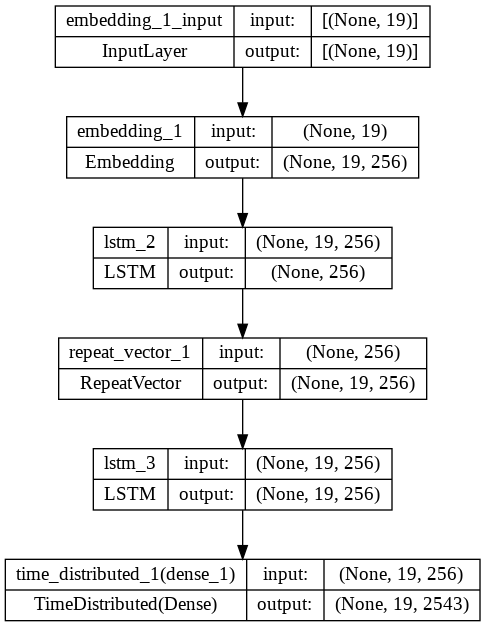

## Cargar modelo

In [20]:
model = load_model('model.h5')

# Procesar Salida

In [23]:
# asignar un número entero a una palabra
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

# asignar una palabra a un número entero
def id_for_word(palabra, tokenizer):
  for word, index in tokenizer.word_index.items():
    if palabra == word:
      return index
  return None

def predict_sequence(model, tokenizer, source):
  prediction = model.predict(source, verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return' '.join(target)

In [25]:
# evaluar la habilidad del modelo
def evaluate_model(model, sources, raw_dataset,target):
 actual, predicted = list(), list()
 for i, source in enumerate(sources):
  # traducir el texto fuente codificado
  source = source.reshape((1, source.shape[0]))
  translation = predict_sequence(model, target, source)
  raw_target, raw_src = raw_dataset[i]
  if i < 20:
   print('src=[%s], target=[%s], predicted=[%s]'% (raw_src, raw_target, translation))
   actual.append(raw_target.split())
   predicted.append(translation.split())
   if i==19: break

In [26]:
# conjuntos de datos de carga
dataset = load_clean_sentences('bd-gd-both.pkl')
train = load_clean_sentences('bd-gd-train.pkl')
test = load_clean_sentences('bd-gd-test.pkl')
# preparar tokenizer para direcciones correctas
gd_tokenizer = create_tokenizer(dataset[:, 0])
gd_vocab_size = len(gd_tokenizer.word_index) + 1
gd_length = max_length(dataset[:, 0])
# preparar tokenizer para direcciones incorrectas
bd_tokenizer = create_tokenizer(dataset[:, 1])
bd_vocab_size = len(bd_tokenizer.word_index) + 1
bd_length = max_length(dataset[:, 1])
# preparar los datos
trainX = encode_sequences(bd_tokenizer, bd_length, train[:, 1])
testX = encode_sequences(bd_tokenizer, bd_length, test[:, 1])

## Resultado

**Son Direcciones Georreferenciadas**

In [29]:
# probar en algunas secuencias de prueba
evaluate_model(model, trainX, train, gd_tokenizer)
print('')
# probar en algunas secuencias de prueba
evaluate_model(model, testX, test, gd_tokenizer)

src=[crr 9 bis num 40-28 sur puerto rico (lo], target=[kr 9 bis # 40 - 28 sur], predicted=[kr 9 bis 40 28 sur]
src=[carrera 18 c # 28 a 25 sur olaya], target=[cl. 28a sur #25-36 18, bogota, colombia], predicted=[cra 10b 28 25 25 medellin bogota bogota colombia colombia]
src=[cll 39 a # 108-26 dan avier 20 juli dan avier 20 ju], target=[cl 39a # 108 - 26], predicted=[cl 39a 108 26]
src=[cr. 51 a nro. 92-63 aranjuez], target=[kr 51a # 92 - 63], predicted=[kr 51a 92 63]
src=[cr. 53a nro.45-09 centro], target=[kr 53a # 45 - 9], predicted=[kr 53a 45 9]
src=[cr 78 no 69 b-58 sur llanito de bosa], target=[kr 78 # 69b - 58 sur], predicted=[kr 78 69a 58 sur]
src=[av carrera 80 13 06 vision colombia], target=[ak 80 # 13 - 6], predicted=[ak 80 13 6]
src=[cl. 50 nro. 71-80 ofi 102 estadio], target=[cl 50 # 71 - 80], predicted=[cl 50 71 80]
src=[cr 43 38a sur -55 apto 103 linares], target=[kr 43 # 38a sur - 55], predicted=[kr 43 38a sur 55]
src=[cr. 81 bis nro. 22 - 76 modelia], target=[kr 81 bis #

In [33]:
def clean_pairs(lines):
 cleaned = list()
 # preparar a regex para el filtrado de caracteres
 re_punc = re.compile('[%s]'% re.escape('''!"$%&'()*+, /:;<=>?@[\]^_`{|}~'''))
 re_print = re.compile('[^%s]'% re.escape(string.printable))
 for pair in lines:
  clean_pair = list()
  for line in pair:
   # normalizar los caracteres unicode
   line = normalize('NFD', line).encode('ascii','ignore')
   line = line.decode('UTF-8')
   # tokenize en espacio en blanco
   line = line.split()
   # convertir a minúsculas
   line = [word.lower() for word in line]
   # eliminar la puntuación de cada token
   line = [re_punc.sub('', w) for w in line]
   # eliminar caracteres no imprimibles de cada token
   line = [re_print.sub('', w) for w in line]
   # store como cadena
   clean_pair.append(' '.join(line))
  cleaned.append(clean_pair)
 return np.array(cleaned)
dataset = load_clean_sentences('bd-gd-both.pkl')

pairs = [['cl 6a # 94a - 25', 'cr 96a 75 40 int 16a vll madrig'],
         ['sin georreferenciacion' , 'cl 100 74c 34 b 12 de octubre 12 de o']]
# oraciones limpias
clean_pairs = clean_pairs(pairs)
# guardar pares limpios en un archivo
save_clean_data(clean_pairs,'bd.pkl')
# control al azar
for i in range(2):
  print('[%s] => [%s]'% (clean_pairs[i,0], clean_pairs[i,1]))

# conjuntos de datos de carga
dataset2 = np.array([['cl 6a # 94a - 25', 'cr 96a 75 40 int 16a vll madrig'],
       ['sin georreferenciacion' , 'cl 100 74c 34 b 12 de octubre 12 de o']], dtype='<U119')
# preparar tokenizer alemán
target_tokenizer = create_tokenizer(dataset2[:, 1])
# preparar los datos
trainX = encode_sequences(bd_tokenizer, bd_length, dataset2[:, 1])
evaluate_model(model, trainX, dataset2, gd_tokenizer)

Saved: bd.pkl
[cl 6a # 94a - 25] => [cr 96a 75 40 int 16a vll madrig]
[sin georreferenciacion] => [cl 100 74c 34 b 12 de octubre 12 de o]
src=[cr 96a 75 40 int 16a vll madrig], target=[cl 6a # 94a - 25], predicted=[kr 96a 75 40]
src=[cl 100 74c 34 b 12 de octubre 12 de o], target=[sin georreferenciacion], predicted=[cl 100 59a 34]


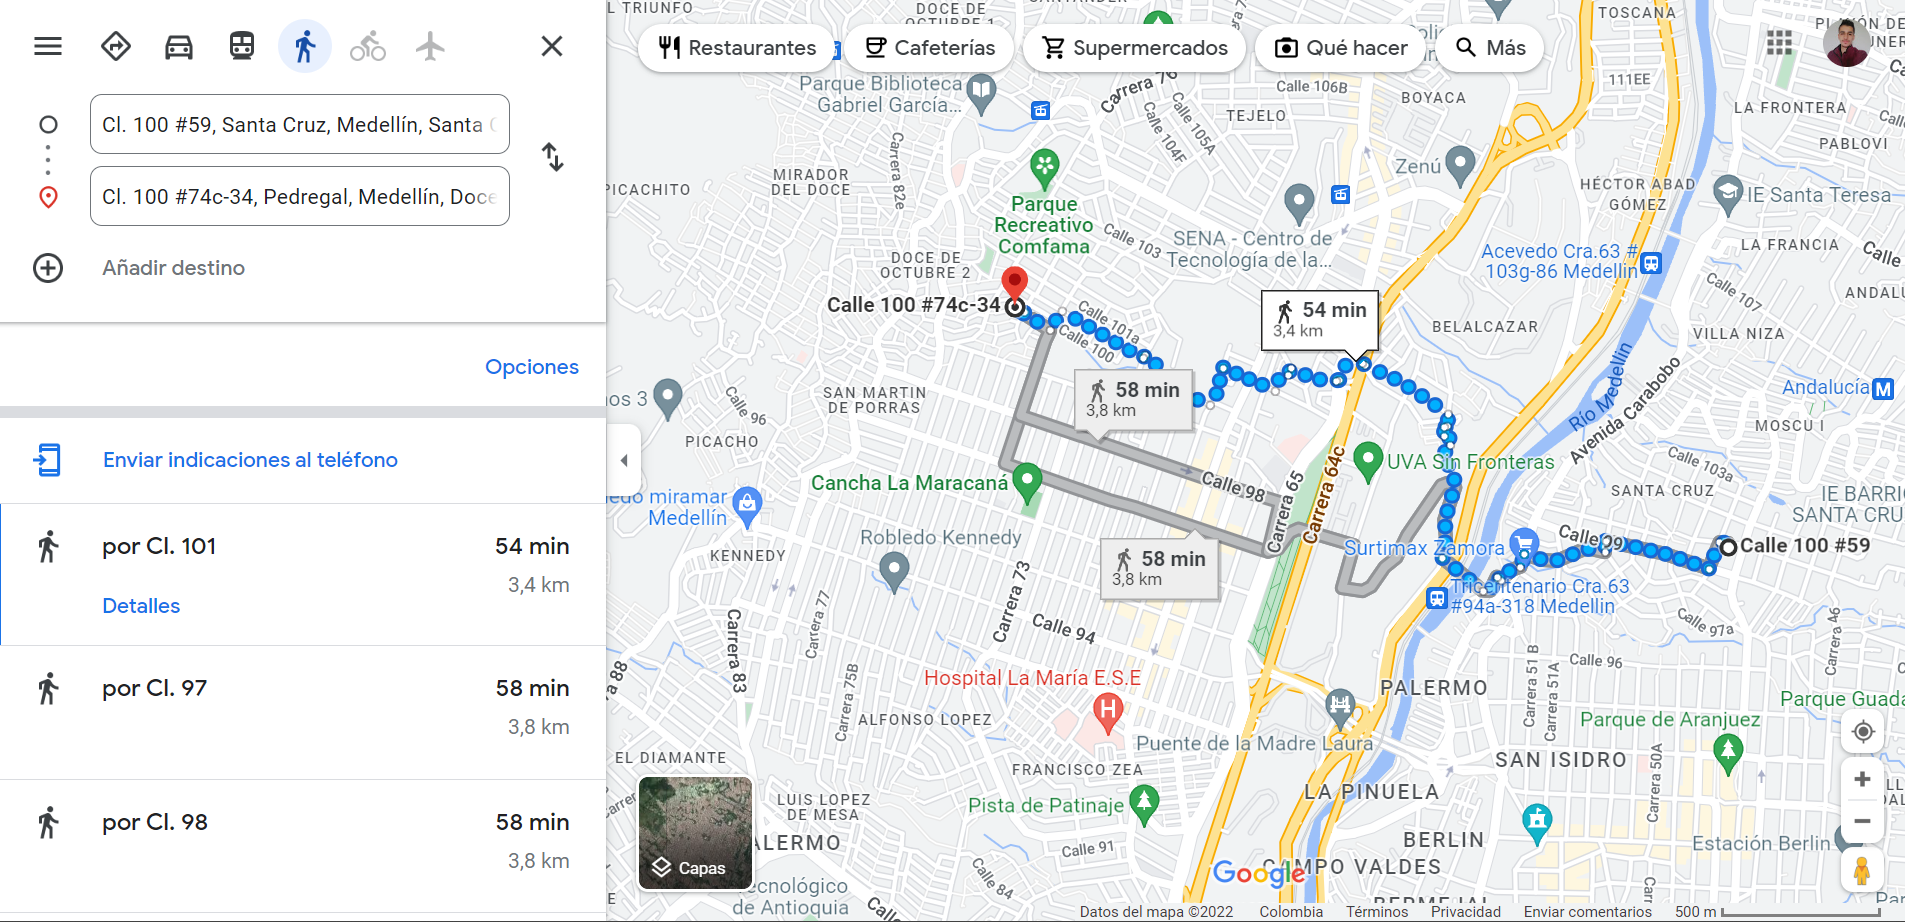

# Ejemplos sin georreferenciacion 

In [34]:


def clean_pairs(lines):
 cleaned = list()
 # preparar a regex para el filtrado de caracteres
 re_punc = re.compile('[%s]'% re.escape('''!"$%&'()*+, /:;<=>?@[\]^_`{|}~'''))
 re_print = re.compile('[^%s]'% re.escape(string.printable))
 for pair in lines:
  clean_pair = list()
  for line in pair:
   # normalizar los caracteres unicode
   line = normalize('NFD', line).encode('ascii','ignore')
   line = line.decode('UTF-8')
   # tokenize en espacio en blanco
   line = line.split()
   # convertir a minúsculas
   line = [word.lower() for word in line]
   # eliminar la puntuación de cada token
   line = [re_punc.sub('', w) for w in line]
   # eliminar caracteres no imprimibles de cada token
   line = [re_print.sub('', w) for w in line]
   # eliminar tokens con números en ellos
   # store como cadena
   clean_pair.append(' '.join(line))
  cleaned.append(clean_pair)
 return np.array(cleaned)

connmysl = mysql.connector.connect()
cursormysl = connmysl.cursor()
cursormysl.execute()
Sin_geo = pd.DataFrame(cursormysl.fetchall()).rename(columns= {0: 'direccion',1: 'rpta'})
Sin_geo['address']='sin georreferenciacion'

direc=[]
for i in range(len(Sin_geo)):
  di=Sin_geo['direccion'][i]
  direc.append(di[0:40])
Sin_geo['direccion']=direc

Sin_geo=Sin_geo.loc[:,['address','direccion']]
np.savetxt('sgeo.txt', Sin_geo.values, fmt='%s',delimiter='\t',newline='\n')
# cargar conjunto de datos
# dividido en parejas 
pairs = to_pairs(load_doc('sgeo.txt'))
# oraciones limpias
clean_pairs = clean_pairs(pairs)
# guardar pares limpios en un archivo
save_clean_data(clean_pairs,'bd.pkl')
# control al azar
for i in range(100):
  print('[%s] => [%s]'% (clean_pairs[i,1], clean_pairs[i,0]))

# conjuntos de datos de carga
dataset2 = load_clean_sentences('bd.pkl')
# preparar tokenizer 
bd_tokenizer = create_tokenizer(dataset2[:, 1])
# preparar los datos
trainX = encode_sequences(bd_tokenizer, bd_length, dataset2[:, 1])
evaluate_model(model, trainX, dataset2, gd_tokenizer)

Saved: bd.pkl
[60 bloque 7 apt 424 calasan calasania] => [sin georreferenciacion]
[cl 100 74c 34 b 12 de octubre 12 de o] => [sin georreferenciacion]
[cl 31 bb #89e - 114 un altos del castil] => [sin georreferenciacion]
[calle 118 #65-88 las brisas medellinant] => [sin georreferenciacion]
[cll 68 # 8757 interion 116 roleo palenq] => [sin georreferenciacion]
[cl. 11 nro.53-03 la tierra caic] => [sin georreferenciacion]
[calle 34 c # 88 b 55 bloque 8 apto 415] => [sin georreferenciacion]
[cr 31 # 68 - b 29 casa versalles  co] => [sin georreferenciacion]
[cr 26c #38a - 68int 202casa segundo pi] => [sin georreferenciacion]
[calle 39 a sur num 28 - 06  apto 608 sa] => [sin georreferenciacion]
[carrera 41 # 49 - 52 apartamento 1401 ] => [sin georreferenciacion]
[cl. 40 a #38 b -50 bsalvador salvador] => [sin georreferenciacion]
[cr 52 # 12 a sur 139 interior 126 guay] => [sin georreferenciacion]
[cra 129 # 61 - 26 san cristobain] => [sin georreferenciacion]
[calle 43 # 79 - 55 b america la c